In [ ]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt


In [ ]:
def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

In [ ]:
raw_text = """During my second month of nursing school, our professor gave us a pop quiz.  
I was a conscientious student and had breezed through the questions, until I read the last one: 
“What is the first name of the woman who cleans the school?”  Surely this was some kind of joke. 
I had seen the cleaning woman several times. She was tall, dark-haired and in her 50s, but how would I know her name?  
I handed in my paper, leaving the last question blank.  Before class ended, one student asked if the last question would count toward our quiz grade.  
“Absolutely,” said the professor.  “In your careers you will meet many people. All are significant. They deserve your attention and care, 
even if all you do is smile and say ‘hello’. I’ve never forgotten that lesson. I also learned her name was Dorothy.""".split()

In [ ]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
EMDEDDING_DIM = 100

# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(raw_text)
vocab_size = len(vocab)

word_list = list(vocab)

word_to_ix = {word:ix for ix, word in enumerate(vocab)}
ix_to_word = {ix:word for ix, word in enumerate(vocab)}




In [ ]:
def CBOW(raw_text, window_size=2):
    data = []
    for i in range(window_size, len(raw_text) - window_size):
        context = [raw_text[i - window_size], raw_text[i - (window_size - 1)], raw_text[i + (window_size - 1)], raw_text[i + window_size]]
        target = raw_text[i]
        data.append((context, target))

    return data


data = CBOW(raw_text)
data[0]

(['During', 'my', 'month', 'of'], 'second')

In [ ]:
class CBOW_Model(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW_Model, self).__init__()

        #out: 1 x emdedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.activation_function1 = nn.ReLU()
        
        #out: 1 x vocab_size
        self.linear2 = nn.Linear(128, vocab_size)
        

    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1,-1)
        out = self.linear1(embeds)
        out = self.activation_function1(out)
        out = self.linear2(out)
        return out

    def get_word_emdedding(self, word):
        word = torch.tensor([word_to_ix[word]])
        return self.embeddings(word).view(1,-1)

In [ ]:
model = CBOW_Model(vocab_size, EMDEDDING_DIM)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
#TRAINING
for epoch in range(50):
    total_loss = 0

    for context, target in data:
        context_vector = make_context_vector(context, word_to_ix)  

        log_probs = model(context_vector)

        total_loss += loss_function(log_probs, torch.tensor([word_to_ix[target]]))

    #optimize at the end of each epoch
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

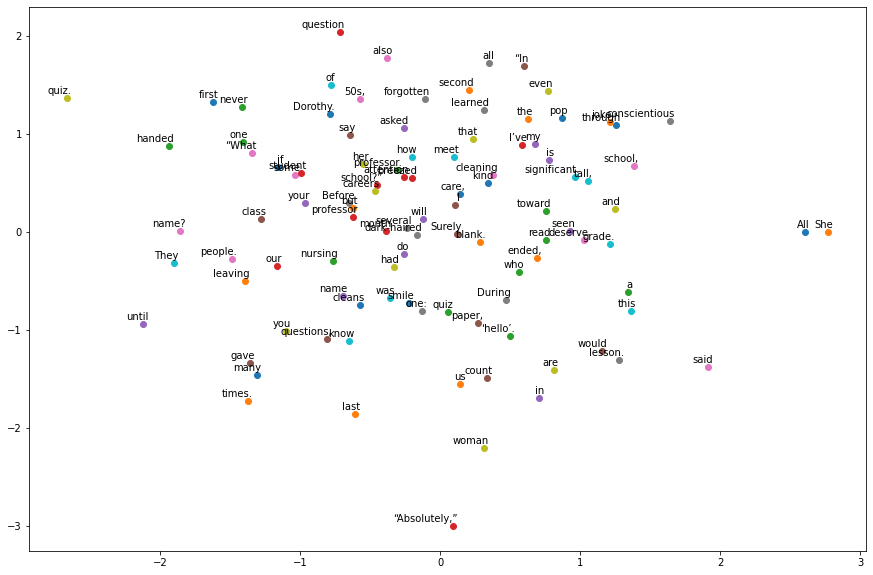

In [ ]:
plt.figure(figsize=(15,10))
for w in word_list:
    x = model.get_word_emdedding(w).detach().data.numpy()[0][0]
    y = model.get_word_emdedding(w).detach().data.numpy()[0][1]
    plt.scatter(x, y)
    plt.annotate(w, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()

In [ ]:
def CBOW_test(test_data, model):
    correct_ct = 0

    for context, target in data:
        context_vector = make_context_vector(context, word_to_ix)  
        model.zero_grad()
        predicted = torch.argmax(model(context_vector), 1)

        if predicted[0] == torch.tensor([word_to_ix[target]]):
                correct_ct += 1

    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

In [ ]:
CBOW_test(data, model)

Accuracy: 100.0% (138/138)


In [ ]:
#TESTING
context = ['I’ve', 'never', 'that', 'lesson.']
context_vector = make_context_vector(context, word_to_ix)
a = model(context_vector)


In [ ]:
#Print result
print(f'Raw text: {" ".join(raw_text)}\n')
print(f'Context: {context}\n')
print(f'Prediction: {ix_to_word[torch.argmax(a[0]).item()]}')

Raw text: During my second month of nursing school, our professor gave us a pop quiz. I was a conscientious student and had breezed through the questions, until I read the last one: “What is the first name of the woman who cleans the school?” Surely this was some kind of joke. I had seen the cleaning woman several times. She was tall, dark-haired and in her 50s, but how would I know her name? I handed in my paper, leaving the last question blank. Before class ended, one student asked if the last question would count toward our quiz grade. “Absolutely,” said the professor. “In your careers you will meet many people. All are significant. They deserve your attention and care, even if all you do is smile and say ‘hello’. I’ve never forgotten that lesson. I also learned her name was Dorothy.

Context: ['I’ve', 'never', 'that', 'lesson.']

Prediction: forgotten
